### Load and Inspect the Dataset

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('arxiv_train.csv')
test_df = pd.read_csv('arxiv_test.csv')

# Data exploration

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.info()
train_df.head()


Train shape: (80000, 3)
Test shape: (20000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  80000 non-null  int64 
 1   abstract    80000 non-null  object
 2   label       80000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


,Unnamed: 0,abstract,label
0,31716,Automatic meeting analysis is an essential f...,eess
1,89533,We propose a protocol to encode classical bi...,quant-ph
2,82700,A number of physically intuitive results for...,quant-ph
3,78830,In the last decade rare-earth hexaborides ha...,physics
4,94948,We introduce the weak barycenter of a family...,stat


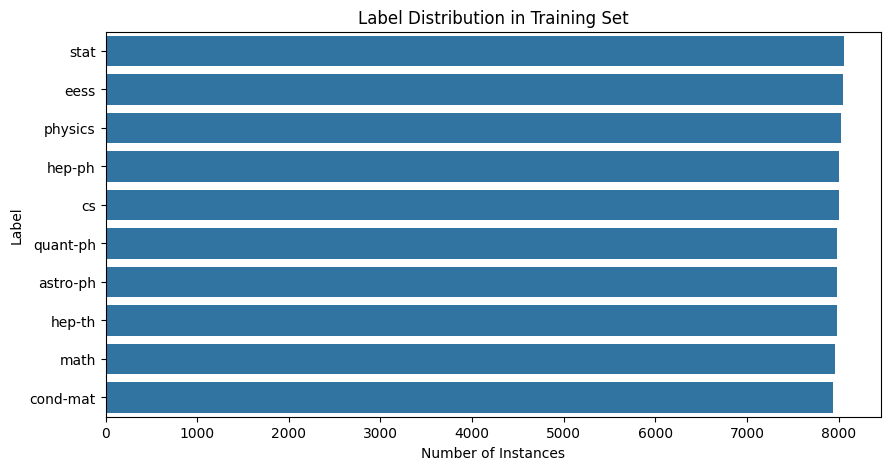

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index)
plt.title('Label Distribution in Training Set')
plt.xlabel('Number of Instances')
plt.ylabel('Label')
plt.show()


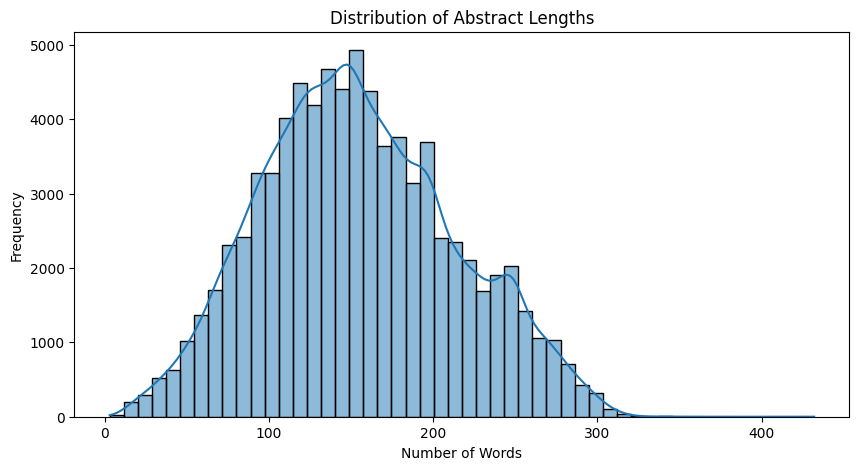

In [5]:
train_df['abstract_length'] = train_df['abstract'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 5))
sns.histplot(train_df['abstract_length'], bins=50, kde=True)
plt.title('Distribution of Abstract Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


### starting preprocessing you lame ass nigga

- checking null values

In [6]:
print("Train missing values:\n", train_df.isnull().sum())
print("Test missing values:\n", test_df.isnull().sum())

Train missing values:
 Unnamed: 0         0
abstract           0
label              0
abstract_length    0
dtype: int64
Test missing values:
 Unnamed: 0    0
abstract      0
label         0
dtype: int64


- removing na

In [7]:
train_df.dropna(subset=['abstract', 'label'], inplace=True)
test_df.dropna(subset=['abstract', 'label'], inplace=True)

- removing extra spaces, new lines, tabs

In [8]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

train_df['clean_abstract'] = train_df['abstract'].apply(clean_text)
test_df['clean_abstract'] = test_df['abstract'].apply(clean_text)


 Apply the Tokenization to Your DataFrame

In [9]:
def simple_tokenize(text):
    # use re.findall to grab sequences of word characters (letters/numbers)
    tokens = re.findall(r'\b\w+\b', text) 
    return tokens

train_df['tokens'] = train_df['clean_abstract'].apply(simple_tokenize)
test_df['tokens'] = test_df['clean_abstract'].apply(simple_tokenize)

print(train_df[['clean_abstract', 'tokens']].head())
print(type(train_df['clean_abstract'].iloc[0]))
print(train_df.columns)


                                      clean_abstract  \
0  automatic meeting analysis is an essential fun...   
1  we propose a protocol to encode classical bits...   
2  a number of physically intuitive results for t...   
3  in the last decade rare-earth hexaborides have...   
4  we introduce the weak barycenter of a family o...   

                                              tokens  
0  [automatic, meeting, analysis, is, an, essenti...  
1  [we, propose, a, protocol, to, encode, classic...  
2  [a, number, of, physically, intuitive, results...  
3  [in, the, last, decade, rare, earth, hexaborid...  
4  [we, introduce, the, weak, barycenter, of, a, ...  
<class 'str'>
Index(['Unnamed: 0', 'abstract', 'label', 'abstract_length', 'clean_abstract',
       'tokens'],
      dtype='object')


- encoding labels as integers because its a multiclass problem

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
test_df['label_encoded'] = label_encoder.transform(test_df['label'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {'astro-ph': 0, 'cond-mat': 1, 'cs': 2, 'eess': 3, 'hep-ph': 4, 'hep-th': 5, 'math': 6, 'physics': 7, 'quant-ph': 8, 'stat': 9}


- Stratified Train/Dev Split

In [11]:
from sklearn.model_selection import train_test_split

# Stratified split on the encoded labels
train_texts, dev_texts, train_labels, dev_labels = train_test_split(
    train_df['clean_abstract'],
    train_df['label_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=train_df['label_encoded']
)

# Optional sanity check: label distribution
print("Train label distribution:\n", train_labels.value_counts(normalize=True))
print("Dev label distribution:\n", dev_labels.value_counts(normalize=True))

Train label distribution:
 label_encoded
9    0.100687
3    0.100656
7    0.100281
4    0.100125
2    0.100062
0    0.099844
8    0.099828
5    0.099766
6    0.099469
1    0.099281
Name: proportion, dtype: float64
Dev label distribution:
 label_encoded
9    0.100687
3    0.100625
7    0.100312
4    0.100125
2    0.100062
8    0.099875
0    0.099812
5    0.099750
6    0.099500
1    0.099250
Name: proportion, dtype: float64


In [12]:
y_train = train_labels.values
y_dev = dev_labels.values
label_map = {'astro-ph': 0, 'cond-mat': 1, 'cs': 2, 'eess': 3, 'hep-ph': 4,
             'hep-th': 5, 'math': 6, 'physics': 7, 'quant-ph': 8, 'stat': 9}

# step 1 : text vectorization

- basic count vectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=10000, stop_words='english')

X_train_count = count_vectorizer.fit_transform(train_texts)
X_dev_count = count_vectorizer.transform(dev_texts)

print("CountVectorizer shape (train):", X_train_count.shape)
print("CountVectorizer shape (dev):", X_dev_count.shape)


CountVectorizer shape (train): (64000, 10000)
CountVectorizer shape (dev): (16000, 10000)


- TF-IDF Vectorization

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_dev_tfidf = tfidf_vectorizer.transform(dev_texts)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (dev):", X_dev_tfidf.shape)


TF-IDF shape (train): (64000, 10000)
TF-IDF shape (dev): (16000, 10000)


# building MLP

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report

- converting data to tensors

# run this for BOW tensors

In [16]:

X_train_tensor = torch.tensor(X_train_count.toarray(), dtype=torch.float32)
X_dev_tensor = torch.tensor(X_dev_count.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=64)

- definfing the model

In [17]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super(FeedforwardNN, self).__init__()
        layers = []
        current_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(current_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3)) 
            current_dim = h
        layers.append(nn.Linear(current_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FeedforwardNN(input_dim=10000, hidden_dims=[128], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

Epoch 1/5 - Loss: 1180.1956
Epoch 2/5 - Loss: 587.2595
Epoch 3/5 - Loss: 484.7521
Epoch 4/5 - Loss: 423.4591
Epoch 5/5 - Loss: 376.0135


### val results

Accuracy on dev set: 84.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1597
           1       0.83      0.81      0.82      1588
           2       0.74      0.70      0.72      1601
           3       0.79      0.81      0.80      1610
           4       0.94      0.94      0.94      1602
           5       0.91      0.92      0.92      1596
           6       0.84      0.87      0.86      1592
           7       0.72      0.70      0.71      1605
           8       0.88      0.87      0.88      1598
           9       0.80      0.86      0.83      1611

    accuracy                           0.84     16000
   macro avg       0.84      0.84      0.84     16000
weighted avg       0.84      0.84      0.84     16000


Confusion Matrix:
[[1494    0    4    2   19    9    3   56    1    9]
 [   0 1279    8    4    2   25   19  172   73    6]
 [   0    1 1116  204    1    0   86   25   11  157]
 [   3    0

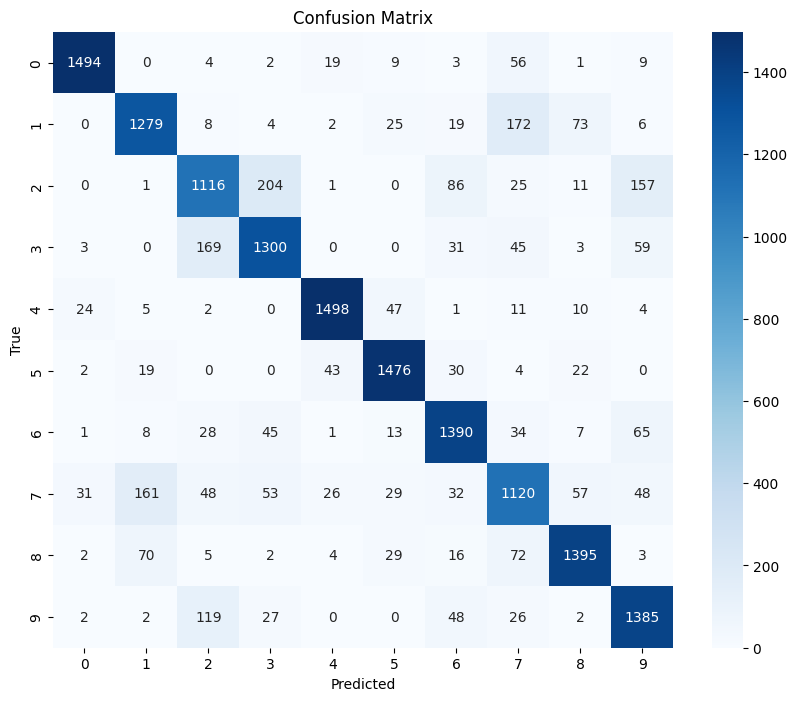

In [19]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dev_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on dev set: {accuracy:.2f}%')

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### test

CountVectorizer shape (test): (20000, 10000)
Accuracy on test set: 83.88%

Test Set Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.95      0.93      0.94      2013
    cond-mat       0.83      0.81      0.82      2058
          cs       0.76      0.70      0.73      1995
        eess       0.78      0.80      0.79      1948
      hep-ph       0.93      0.92      0.92      1990
      hep-th       0.89      0.91      0.90      2019
        math       0.85      0.88      0.87      2042
     physics       0.71      0.69      0.70      1977
    quant-ph       0.87      0.88      0.88      2013
        stat       0.80      0.85      0.83      1945

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



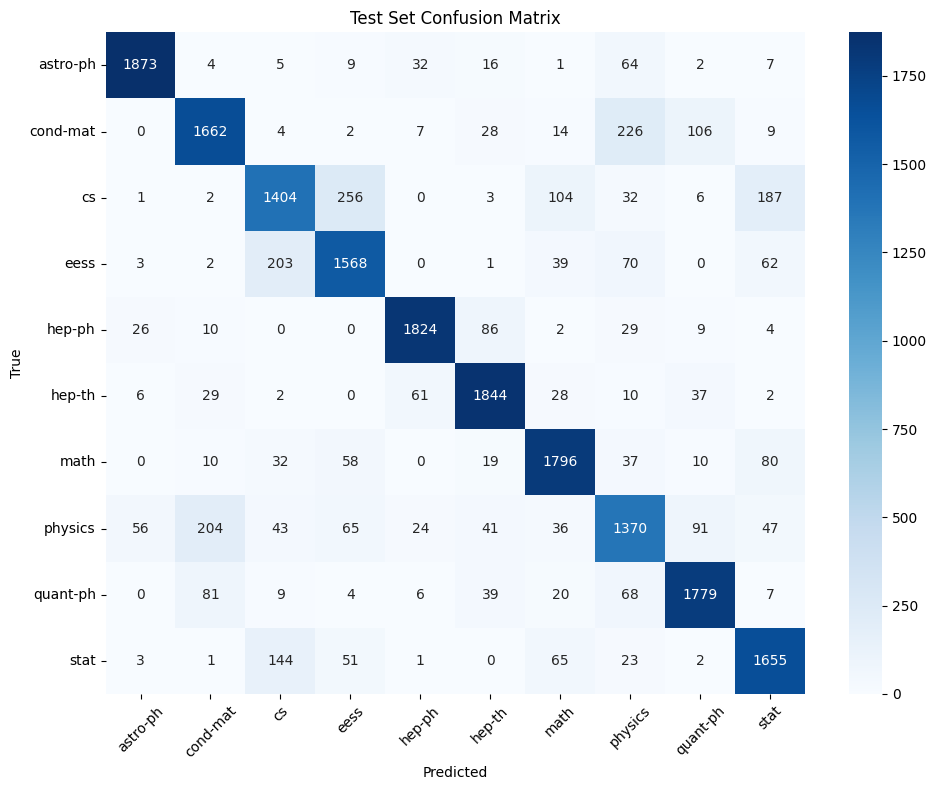

In [20]:
X_test_count = count_vectorizer.transform(test_df['clean_abstract'])
y_test = test_df['label_encoded'].values

print("CountVectorizer shape (test):", X_test_count.shape)

X_test_tensor = torch.tensor(X_test_count.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(batch_y.cpu().numpy())
        
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Accuracy on test set: {test_accuracy:.2f}%')
print("\nTest Set Classification Report:")
print(classification_report(all_test_labels, all_test_preds, 
                           target_names=label_encoder.classes_))

plt.figure(figsize=(10, 8))
cm_test = confusion_matrix(all_test_labels, all_test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# TF-IDF tensors

In [21]:
X_train_tensor_tf = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_dev_tensor_tf = torch.tensor(X_dev_tfidf.toarray(), dtype=torch.float32)

train_dataset_tf = TensorDataset(X_train_tensor_tf, y_train_tensor)
dev_dataset_tf = TensorDataset(X_dev_tensor_tf, y_dev_tensor)

train_loader_tf = DataLoader(train_dataset_tf, batch_size=64, shuffle=True)
dev_loader_tf = DataLoader(dev_dataset_tf, batch_size=64)

New model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FeedforwardNN(input_dim=10000, hidden_dims=[256], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader_tf:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

Epoch 1/10 - Loss: 1761.0295
Epoch 2/10 - Loss: 845.8284
Epoch 3/10 - Loss: 603.6478
Epoch 4/10 - Loss: 512.5923
Epoch 5/10 - Loss: 460.4091
Epoch 6/10 - Loss: 424.6225
Epoch 7/10 - Loss: 396.6224
Epoch 8/10 - Loss: 371.9272
Epoch 9/10 - Loss: 351.9572
Epoch 10/10 - Loss: 334.0712


# val

Accuracy on dev set: 84.44%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1597
           1       0.83      0.81      0.82      1588
           2       0.75      0.71      0.73      1601
           3       0.79      0.83      0.81      1610
           4       0.94      0.93      0.94      1602
           5       0.91      0.92      0.92      1596
           6       0.87      0.86      0.86      1592
           7       0.72      0.70      0.71      1605
           8       0.88      0.88      0.88      1598
           9       0.80      0.86      0.83      1611

    accuracy                           0.84     16000
   macro avg       0.84      0.84      0.84     16000
weighted avg       0.84      0.84      0.84     16000


Confusion Matrix:
[[1496    0    3    5   22    8    2   51    1    9]
 [   0 1290   12    3    4   22   18  161   73    5]
 [   0    1 1132  203    0    0   74   30   11  150]
 [   3    0

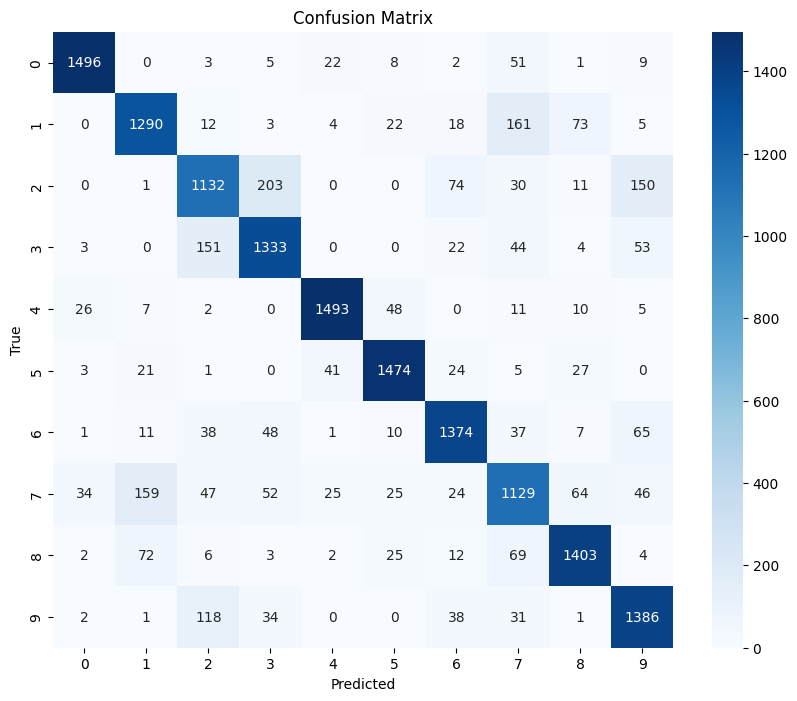

In [23]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in dev_loader_tf:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on dev set: {accuracy:.2f}%')

from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# test

CountVectorizer shape (test): (20000, 10000)
Accuracy on test set: 82.89%

Test Set Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.93      0.94      0.94      2013
    cond-mat       0.79      0.84      0.82      2058
          cs       0.82      0.61      0.70      1995
        eess       0.71      0.88      0.79      1948
      hep-ph       0.93      0.92      0.92      1990
      hep-th       0.87      0.91      0.89      2019
        math       0.94      0.79      0.86      2042
     physics       0.77      0.58      0.66      1977
    quant-ph       0.82      0.91      0.86      2013
        stat       0.74      0.90      0.82      1945

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



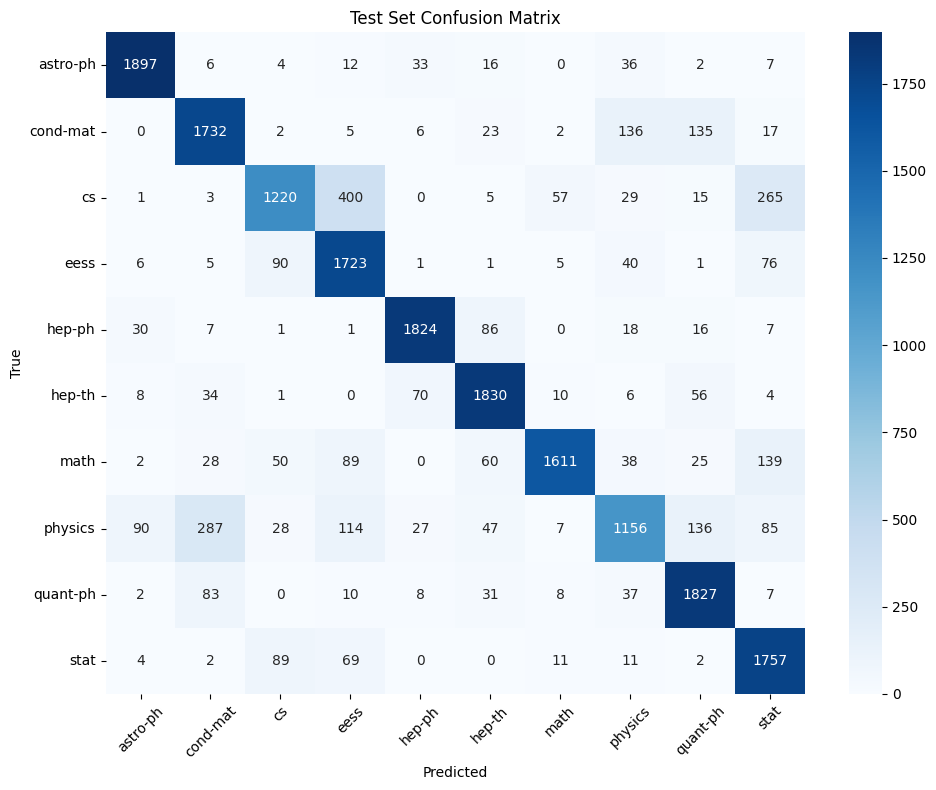

In [24]:
X_test_count = count_vectorizer.transform(test_df['clean_abstract'])
y_test = test_df['label_encoded'].values

print("CountVectorizer shape (test):", X_test_count.shape)

X_test_tensor = torch.tensor(X_test_count.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
test_correct = 0
test_total = 0
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(batch_y.cpu().numpy())
        
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Accuracy on test set: {test_accuracy:.2f}%')

print("\nTest Set Classification Report:")
print(classification_report(all_test_labels, all_test_preds, 
                           target_names=label_encoder.classes_))

plt.figure(figsize=(10, 8))
cm_test = confusion_matrix(all_test_labels, all_test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step two with pretrained embeddings

### Loading Pretrained Word Embeddings

In [25]:
import numpy as np

embedding_index = {}
embedding_dim = 300  

with open('glove.6B.300d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients
        
print("Loaded {} word vectors.".format(len(embedding_index)))

Loaded 400000 word vectors.


 ### Converting Abstracts into Document Vectors

In [26]:
def get_document_vector(tokens, embedding_index, embedding_dim=300, pooling='mean'):
    valid_vectors = [embedding_index[word] for word in tokens if word in embedding_index]
    if not valid_vectors:
        return np.zeros(embedding_dim)
    valid_vectors = np.array(valid_vectors)
    
    if pooling == 'mean':
        return np.mean(valid_vectors, axis=0)
    elif pooling == 'sum':
        return np.sum(valid_vectors, axis=0)
    elif pooling == 'max':
        return np.max(valid_vectors, axis=0)
    else:
        raise ValueError("Unsupported pooling type. Choose 'mean', 'sum', or 'max'.")

### Creating Document Vectors for Training and Test Sets

In [27]:
# for sum pooling
X_train_sum = np.vstack(train_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='sum')))
y_train_sum = train_df['label'].values
X_test_sum = np.vstack(test_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='sum')))
y_test_sum = test_df['label'].values

# for mean pooling
X_train_mean = np.vstack(train_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='mean')))
y_train_mean = train_df['label'].values
X_test_mean = np.vstack(test_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='mean')))
y_test_mean = test_df['label'].values

# for max pooling
X_train_max = np.vstack(train_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='max')))
y_train_max = train_df['label'].values
X_test_max = np.vstack(test_df['tokens'].apply(lambda tokens: get_document_vector(tokens, embedding_index, embedding_dim, pooling='max')))
y_test_max = test_df['label'].values

###  Converting String Labels to Integers

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train_encoded_sum = le.fit_transform(y_train_sum)
y_test_encoded_sum = le.transform(y_test_sum)

y_train_encoded_max = le.fit_transform(y_train_max)
y_test_encoded_max = le.transform(y_test_max)

y_train_encoded_mean = le.fit_transform(y_train_mean)
y_test_encoded_mean = le.transform(y_test_mean)


### 4. Building and Training the MLP Classifier

In [29]:
import tensorflow as tf
to_categorical = tf.keras.utils.to_categorical

num_classes = 10

y_train_cat_sum = to_categorical(y_train_encoded_sum, num_classes=num_classes)
y_test_cat_sum = to_categorical(y_test_encoded_sum, num_classes=num_classes)

y_train_cat_mean = to_categorical(y_train_encoded_mean, num_classes=num_classes)
y_test_cat_mean = to_categorical(y_test_encoded_mean, num_classes=num_classes)

y_train_cat_max = to_categorical(y_train_encoded_max, num_classes=num_classes)
y_test_cat_max = to_categorical(y_test_encoded_max, num_classes=num_classes)


# model for mean pooling

In [30]:
import tensorflow as tf

Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
BatchNormalization = tf.keras.layers.BatchNormalization
model_mean = Sequential()

model_mean.add(Dense(265, activation='relu', input_shape=(embedding_dim,)))
model_mean.add(Dropout(0.3))
model_mean.add(Dense(128, activation='relu'))
model_mean.add(Dropout(0.3))
model_mean.add(Dense(64, activation='relu'))
model_mean.add(Dense(num_classes, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

model_mean.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_mean.summary()

C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 265)            │        79,765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 265)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,719 (479.37 KB)

 Trainable params: 122,719 (479.37 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history_mean = model_mean.fit(X_train_mean, y_train_cat_mean, epochs=15, batch_size=16, validation_data=(X_test_mean, y_test_cat_mean))

Epoch 1/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4992 - loss: 1.4016 - val_accuracy: 0.7294 - val_loss: 0.7642
Epoch 2/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.7143 - loss: 0.8218 - val_accuracy: 0.7548 - val_loss: 0.7014
Epoch 3/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7374 - loss: 0.7559 - val_accuracy: 0.7595 - val_loss: 0.6786
Epoch 4/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7501 - loss: 0.7189 - val_accuracy: 0.7652 - val_loss: 0.6562
Epoch 5/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7587 - loss: 0.6913 - val_accuracy: 0.7712 - val_loss: 0.6454
Epoch 6/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7633 - loss: 0.6741 - val_accuracy: 0.7732 - val_loss: 0.6366
Epoch 7/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7681 - loss: 0.6601 - val_accuracy: 0.7731 - val_loss: 0.6330
Epoch 8/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7735 - loss: 0

In [33]:
loss, accuracy = model_mean.evaluate(X_test_mean, y_test_cat_mean)
print("Test Accuracy:", accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7810 - loss: 0.6058
Test Accuracy: 0.7856000065803528


In [36]:
y_pred_probs_mean = model_mean.predict(X_test_mean)
y_pred_mean = np.argmax(y_pred_probs_mean, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_encoded_mean, y_pred_mean))


625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2013
           1       0.70      0.83      0.76      2058
           2       0.77      0.59      0.67      1995
           3       0.69      0.83      0.76      1948
           4       0.87      0.88      0.88      1990
           5       0.82      0.85      0.84      2019
           6       0.87      0.79      0.83      2042
           7       0.74      0.46      0.57      1977
           8       0.83      0.82      0.83      2013
           9       0.70      0.87      0.77      1945

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.78     20000
weighted avg       0.79      0.79      0.78     20000



In [37]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


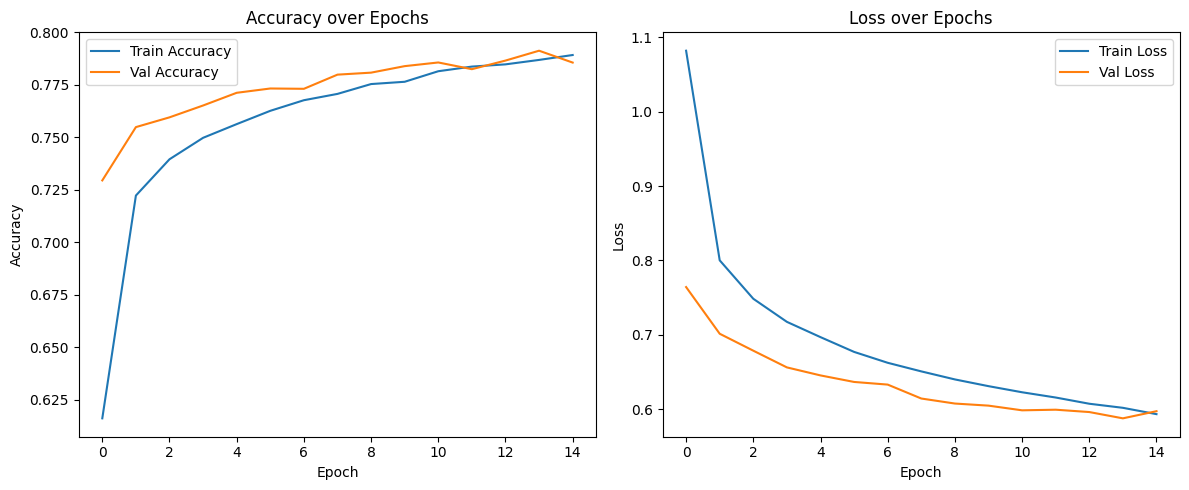

In [38]:
plot_training_history(history_mean)

# model for max pooling 

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU


Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
BatchNormalization = tf.keras.layers.BatchNormalization
model_max = Sequential()

model_max.add(Dense(1024))
model_max.add(LeakyReLU(alpha=0.1))
model_max.add(BatchNormalization())
model_max.add(Dense(512, activation='relu', input_shape=(embedding_dim,)))
model_max.add(Dropout(0.5))
model_max.add(Dense(265, activation='relu', input_shape=(embedding_dim,)))
model_max.add(Dropout(0.4))
model_max.add(Dense(128, activation='relu'))
model_max.add(Dropout(0.3))
model_max.add(Dense(64, activation='relu'))
model_max.add(Dense(num_classes, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_max.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_max.summary()

C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [40]:
history_max = model_max.fit(X_train_max, y_train_cat_max, epochs=15, batch_size=16, validation_data=(X_test_max, y_test_cat_max))

Epoch 1/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 138s 24ms/step - accuracy: 0.3756 - loss: 1.7565 - val_accuracy: 0.6785 - val_loss: 0.9440
Epoch 2/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 122s 24ms/step - accuracy: 0.6343 - loss: 1.0738 - val_accuracy: 0.6910 - val_loss: 0.8880
Epoch 3/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 139s 28ms/step - accuracy: 0.6603 - loss: 0.9973 - val_accuracy: 0.6748 - val_loss: 0.9345
Epoch 4/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 140s 28ms/step - accuracy: 0.6661 - loss: 0.9781 - val_accuracy: 0.6891 - val_loss: 0.8765
Epoch 5/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 133s 27ms/step - accuracy: 0.6750 - loss: 0.9461 - val_accuracy: 0.6901 - val_loss: 0.8980
Epoch 6/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 136s 27ms/step - accuracy: 0.6787 - loss: 0.9305 - val_accuracy: 0.7128 - val_loss: 0.8391
Epoch 7/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 135s 27ms/step - accuracy: 0.6872 - loss: 0.9007 - val_accuracy: 0.7099 - val_loss: 0.8353
Epoch 8/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 99s 18ms/step - accuracy: 0

In [42]:
loss_max, accuracy_max = model_max.evaluate(X_test_max, y_test_cat_max)
print("Test Accuracy:", accuracy_max)

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7315 - loss: 0.7593
Test Accuracy: 0.7299500107765198


In [ ]:
y_pred_probs_max = model_max.predict(X_test_max)
y_pred_max = np.argmax(y_pred_probs_max, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_encoded_max, y_pred_max))


625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2013
           1       0.80      0.57      0.66      2058
           2       0.56      0.71      0.63      1995
           3       0.70      0.62      0.65      1948
           4       0.88      0.84      0.86      1990
           5       0.85      0.74      0.79      2019
           6       0.80      0.77      0.79      2042
           7       0.51      0.63      0.56      1977
           8       0.74      0.82      0.78      2013
           9       0.74      0.70      0.72      1945

    accuracy                           0.73     20000
   macro avg       0.74      0.73      0.73     20000
weighted avg       0.74      0.73      0.73     20000



In [45]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


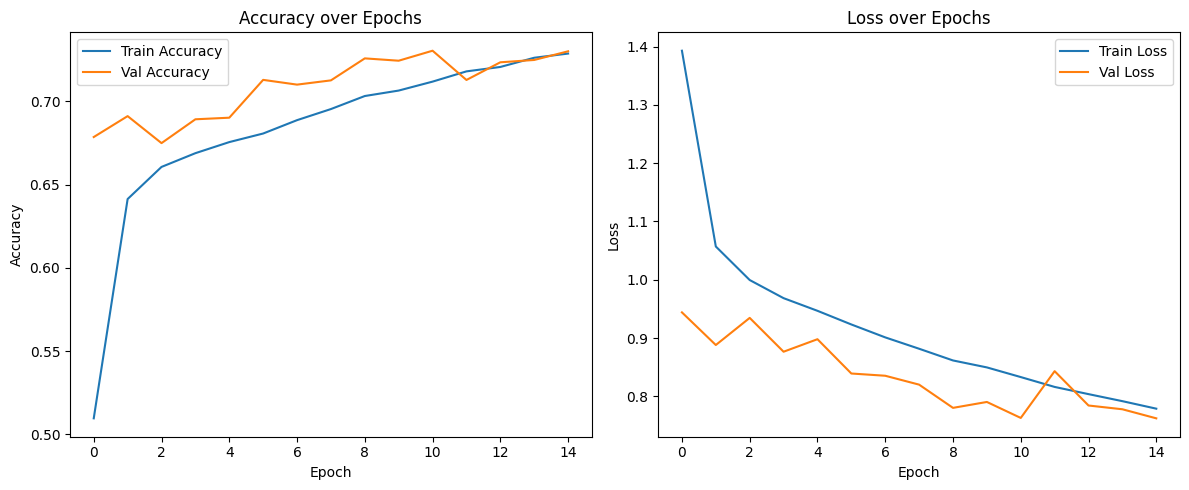

In [46]:
plot_training_history(history_max)

# model for sum pooling

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model_sum = Sequential()
model_sum.add(BatchNormalization(input_shape=(embedding_dim,)))
model_sum.add(Dense(192, activation='relu')) 
model_sum.add(Dropout(0.15))
model_sum.add(Dense(96, activation='relu'))
model_sum.add(Dropout(0.15))
model_sum.add(Dense(48, activation='relu'))
model_sum.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.0002)

model_sum.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model_sum.summary()

C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 192)            │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,666 (322.91 KB)

 Trainable params: 82,066 (320.57 KB)

 Non-trainable params: 600 (2.34 KB)

In [48]:
history_sum = model_sum.fit(
    X_train_sum, y_train_cat_sum,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_sum, y_test_cat_sum),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_sum_pool_model.keras',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]
)


Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.5401 - loss: 1.3234 - val_accuracy: 0.7543 - val_loss: 0.7146
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.7199 - loss: 0.8088 - val_accuracy: 0.7655 - val_loss: 0.6693
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7386 - loss: 0.7573 - val_accuracy: 0.7734 - val_loss: 0.6405
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7479 - loss: 0.7160 - val_accuracy: 0.7727 - val_loss: 0.6408
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.7536 - loss: 0.7058 - val_accuracy: 0.7789 - val_loss: 0.6150
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.7579 - loss: 0.6859 - val_accuracy: 0.7804 - val_loss: 0.6119
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7643 - loss: 0.6702 - val_accuracy: 0.7845 - val_loss: 0.5997
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.7703 - loss: 

In [49]:
loss, accuracy = model_sum.evaluate(X_test_sum, y_test_cat_sum)
print("Test Accuracy:", accuracy)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7953 - loss: 0.5761
Test Accuracy: 0.7996500134468079


In [ ]:
y_pred_probs_sum = model_sum.predict(X_test_sum)
y_pred_sum = np.argmax(y_pred_probs_sum, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_encoded_sum, y_pred_sum))


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2013
           1       0.77      0.78      0.78      2058
           2       0.73      0.65      0.69      1995
           3       0.72      0.81      0.76      1948
           4       0.89      0.89      0.89      1990
           5       0.85      0.84      0.84      2019
           6       0.82      0.84      0.83      2042
           7       0.70      0.60      0.64      1977
           8       0.81      0.86      0.83      2013
           9       0.77      0.81      0.79      1945

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



In [51]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


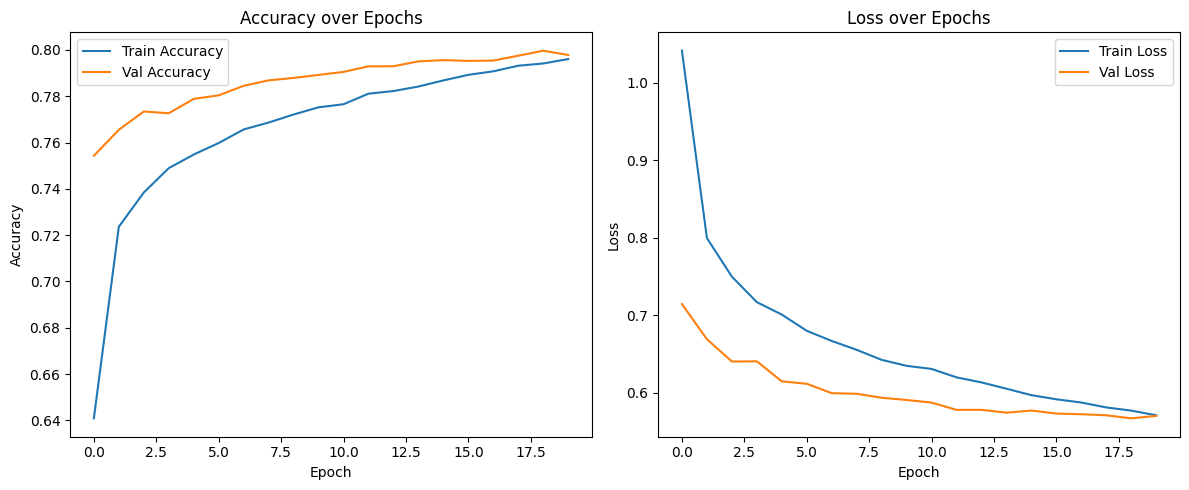

In [52]:
plot_training_history(history_sum)
